### Курс "Машинное обучение", осень 2020

### Занятие 1, кросс-валидация и дилемма смещения-разброса

# Сравнение случайного поиска и поиска по сетке для поиска лучшего набора гиперпараметров

## Вспомогательные функции

### Разбиение базы на обучающую и тестовую

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0) 
print(X.shape, y.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(150, 4) (150,)
(90, 4) (90,) (60, 4) (60,)


### Посмотрим на качество работы на k блоках в k-fold кросс-валидации

In [2]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='linear', C=1)
score = cross_val_score(clf, X_train, y_train, cv=5) 
print(score)

[1.         1.         1.         1.         0.94444444]


### Также можно посмотреть на результат классификации на каждом пример

Обратите внимание, что каждый пример входит ровно в один тестовый под-блок (и вот на нем и выводятся результаты)

In [3]:
from sklearn.model_selection import cross_val_predict

clf = svm.SVC(kernel='linear', C=1)
classes_pred = cross_val_predict(clf, X_train, y_train, cv=5) 
print(classes_pred)
print(np.sum(classes_pred == y_train) / y_train.shape[0])
print(classes_pred.shape)

[1 0 2 1 1 1 1 2 0 0 2 1 0 0 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0
 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 1
 0 1 2 2 0 1 1 2 1 0 0 0 2 1 2 0]
0.9888888888888889
(90,)


### Генератор (на самом деле, итератор) разбиений для k-fold кросс-валидации

In [4]:
from sklearn.model_selection import KFold

X1 = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for train, test in kf.split(X1):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]


### Генератор разбиений для LOO кросс-валидации

In [5]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
for train, test in loo.split(X1):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


### Генератор разбиений для многократной k-fold кросс-валидации

In [6]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=123456)
for train, test in rkf.split(X1):
    print("%s %s" % (train, test))

[1 2] [0 3]
[0 3] [1 2]
[0 1] [2 3]
[2 3] [0 1]


## Поиск гиперпараметров

### Поиск по сетке

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid, cv=5, refit=True) # Refit an estimator using the best found parameters on the whole dataset
clf.fit(X_train, y_train) # Run CV grid search
print(clf.best_params_)
print(clf.best_score_)
score = clf.score(X_test, y_test) # Test on the best parameters
print(score)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9888888888888889
0.9166666666666666


### Случайный поиск по распределению

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {'C': loguniform(0.1, 1000), 'gamma': loguniform(0.0001, 1.0), 'kernel': ['rbf']}
svc = svm.SVC()
clf = RandomizedSearchCV(svc, param_dist, n_iter=25, cv=5, refit=True) # Refit an estimator using the best found parameters on the whole dataset
clf.fit(X_train, y_train) # Run CV grid search
print(clf.best_params_)
print(clf.best_score_)
score = clf.score(X_test, y_test) # Test on the best parameters
print(score)

{'C': 898.8593337566032, 'gamma': 0.0015258394016932596, 'kernel': 'rbf'}
0.9888888888888889
0.9


### Сравнение подходов

Загрузим более представительную базу данных

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import datasets
from sklearn import svm
from scipy.stats import loguniform

X, y = datasets.load_digits(return_X_y=True) # X.shape = (150, 4), y.shape = (150,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456) 
print(X.shape, y.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1797, 64) (1797,)
(1257, 64) (1257,) (540, 64) (540,)


Запускаем поиск по сетке размерности 9*9 = 81

In [10]:
param_grid = {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 
              'gamma': [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001], 'kernel': ['rbf']}
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid, cv=5, refit=True) # Refit an estimator using the best found parameters on the whole dataset
clf.fit(X_train, y_train) # Run CV grid search
print('GridSearchCV params:', clf.best_params_)
score = clf.score(X_test, y_test) # Test on the best parameters
print('GridSearchCV test score:', score)

GridSearchCV params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
GridSearchCV test score: 0.9833333333333333


Запускаем случайный поиск по лог-равномерному распределению (так же, как в сетке), всего 81 раз

In [11]:
param_dist = {'C': loguniform(0.1, 1000), 'gamma': loguniform(0.0001, 1.0), 'kernel': ['rbf']}
svc = svm.SVC()
clf = RandomizedSearchCV(svc, param_dist, n_iter=9*9, cv=5, random_state=123456, refit=True) # Refit an estimator using the best found parameters on the whole dataset
clf.fit(X_train, y_train) # Run CV grid search
print('RandomizedSearchCV params:', clf.best_params_)
score = clf.score(X_test, y_test) # Test on the best parameters
print('RandomizedSearchCV test score:', score)

RandomizedSearchCV params: {'C': 24.193643927107065, 'gamma': 0.0006301690253315956, 'kernel': 'rbf'}
RandomizedSearchCV test score: 0.9888888888888889


Как видим, получилось даже лучше.

Теперь сэкономим время, и запустим всего 10 раз

In [12]:
param_dist = {'C': loguniform(0.1, 1000), 'gamma': loguniform(0.0001, 1.0), 'kernel': ['rbf']}
svc = svm.SVC()
clf = RandomizedSearchCV(svc, param_dist, n_iter=10, cv=5, random_state=123456, refit=True) # Refit an estimator using the best found parameters on the whole dataset
clf.fit(X_train, y_train) # Run CV grid search
print('RandomizedSearchCV params:', clf.best_params_)
score = clf.score(X_test, y_test) # Test on the best parameters
print('RandomizedSearchCV test score:', score)

RandomizedSearchCV params: {'C': 23.940562924593113, 'gamma': 0.00035498845268968515, 'kernel': 'rbf'}
RandomizedSearchCV test score: 0.9888888888888889


**Вывод**: порой не стоит скрупулезно проходить по полной сетке, можно сэкономить время и просэмплировать по распределению, потратив в разы меньше времени!

***

# Дилемма смещения-разброса

## Приближение полиномом и такие разные ошибки на тесте и обучении

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

np.random.seed(seed=123456)

Будем использовать 7 точек и приближать соотв. вплоть до полинома 6 степени (многочлен Лежандра). Целевая зависимость: y = sin(x)

In [62]:
N = 7
x0 = 0
x1 = np.pi / 2 + 1 / 2
x = x0 + (x1 - x0)*np.random.random_sample(N) # np.linspace(x0, x1, N)
eps = np.random.random_sample(N)
y_train = np.sin(x) + 0.2 * eps - 0.1

Строим приближение

In [63]:
poly_coef = []
poly = []

for i in range(N):
    poly_coef.append(np.polyfit(x, y_train, i)) # Find coefficients by MSE
    poly.append(np.poly1d(poly_coef[i])) # Construct polynom from coefficients

Выводим результат. Видим, что начиная с 3-ей степени все уже не очень хорошо - лучше проходим по точкам, но хуже в остальных местах.

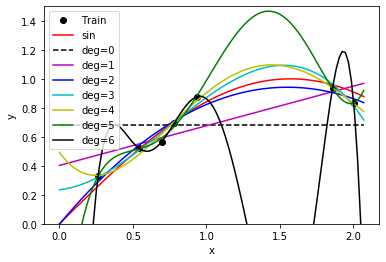

In [64]:
x_gt = np.linspace(x0, x1, 100)
y_gt = np.sin(x_gt)
plt.plot(x, y_train, 'ko', label='Train')
plt.plot(x_gt, y_gt, 'r', label='sin')
cols = ['k--', 'm', 'b', 'c', 'y', 'g', 'k', 'b--']

for i in range(N):
    plt.plot(x_gt, poly[i](x_gt), cols[i], label='deg={}'.format(i))

plt.legend()
plt.ylim(0, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.draw()

Считаем ошибку на обучении (жирные точки) и тесте (другие точки, но с теми же абсциссами)

In [65]:
eps = np.random.random_sample(N)
y_test = np.sin(x) + 0.1 * eps - 0.05

diff_train = []
diff_test = []

for i in range(N):
    diff_train.append(np.mean(np.abs(y_train - poly[i](x))))
    diff_test.append(np.mean(np.abs(y_test - poly[i](x))))

Выводим результат. Как видим, при больших степенях мы все лучше приближаем train, но все хуже test

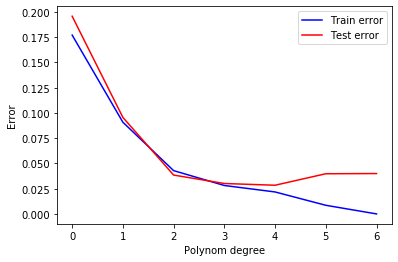

In [66]:
degree = np.linspace(0, N-1, N).astype(np.int32)

plt.plot(degree, diff_train, 'b', label='Train error')
plt.plot(degree, diff_test, 'r', label='Test error')
plt.legend()
plt.xlabel('Polynom degree')
plt.ylabel('Error')
plt.draw()

## Экспериментальная проверка дилеммы смещения-разброса

Проверим выведенную на лекции формулу. 

Для начала готовим данные.

In [232]:
np.random.seed(seed=1234567)
N = 6 # Number of points
N_avg = 1000 # Number of different initializations

x0 = 0
x1 = np.pi / 2 + 1 / 2

xr = x0 + (x1 - x0)*np.random.random_sample(N)

X_train = np.empty((N, N_avg))
Y_train = np.empty((N, N_avg))

X_test = np.empty(N)
Y_test = np.empty(N)

def F(x):
    return np.sin(x)

# train
for i in range(N_avg):
    X_train[:, i] = xr
    Y_train[:, i] = F(X_train[:, i]) + 0.2 * np.random.random_sample(N) - 0.1

# test
X_test = xr
Y_test = F(X_test) + 0.2 * np.random.random_sample(N) - 0.1

Для каждого эксперимента (для разных степеней и для разных уровней шума) вычисляем приближение

In [233]:
poly = np.empty((N, N_avg), dtype=object)

for deg in range(N):
    for i in range(N_avg):
        poly_coef = np.polyfit(X_train[:, i], Y_train[:, i], deg) # Find coefficients by MSE
        poly[deg, i] = np.poly1d(poly_coef) # Construct polynom from coefficients

Рассчитываем значение обученных полиномов

In [234]:
Y_predict = np.empty((N, N_avg, N)) # First dimension for points, last dimension - for deg!

for deg in range(N):
    for i in range(N_avg):
        Y_predict[:, i, deg] = poly[deg, i](X_test)

Самая важная часть: подсчитываем все метрики (уровень шума, смещение и разброс, а также общий уровень ошибки)

In [235]:
var_noise = np.empty(N)
var_predict = np.empty(N)
bias2 = np.empty(N)
error = np.empty(N)

for deg in range(N):
    var_noise[deg] = np.mean(np.var(Y_train - F(X_train), axis=1))
    var_predict[deg] = np.mean(np.var(Y_predict[:, :, deg], axis=1))
    bias2[deg] = np.mean((F(X_test) - np.mean(Y_predict[:, :, deg], axis=1)) ** 2)
    error[deg] = np.mean((Y_test - np.mean(Y_predict[:, :, deg], axis=1))**2)

Строим кривые и убеждаемся, что эмпирически получаем почти полное совпадение с аналитической формулой

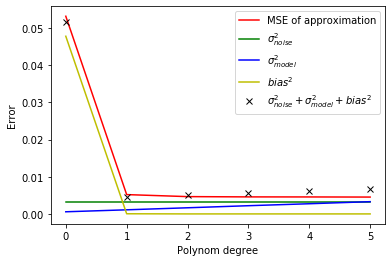

In [236]:
degree = np.linspace(0, N-1, N).astype(np.int32)
plt.plot(degree, error, 'r', label='MSE of approximation')
plt.plot(degree, var_noise, 'g', label='$\sigma_{noise}^2$')
plt.plot(degree, var_predict, 'b', label='$\sigma_{model}^2$')
plt.plot(degree, bias2, 'y', label='$bias^2$')
plt.plot(degree, var_noise + var_predict + bias2, 'kx', label='$\sigma_{noise}^2+\sigma_{model}^2+bias^2$')
plt.legend()
plt.xlabel('Polynom degree')
plt.ylabel('Error')
plt.draw()